In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 11.8 MB/s eta 0:00:00


# MNIST Experimentation

In this file I will experiment with creating a simple image classification network, and then develop it into a simple GAN, from scratch as much as possible. For this, we will be using the MNIST dataset, a dataset of 28x28 pixel images containing handwritten numbers.

## Part I: Data acquisition and EDA

First things first we will download the data and have a look through it to observe the properties of the data we are dealing with.

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip
import tqdm

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [ ]:
print(f"Training input shape: {x_train.shape}")
print(f"Training output shape: {y_train.shape}")
print(f"Validation input shape: {x_valid.shape}")
print(f"Validation output shape: {y_valid.shape}")

Training input shape: (50000, 784)
Training output shape: (50000,)
Validation input shape: (10000, 784)
Validation output shape: (10000,)


In [ ]:
# lets look at our labels

print(f"Label set: {set(y_train)}")

Label set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
example_image = x_train[0]
print(f"Example image raw: \n{example_image}")

Example image raw: 
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.

Obviously this is a little hard to parse, but the important detail is that this is a sparsely populated vector, with values $0 \geq x \geq 1$ . What this points to is a greyscale image where 0 represents white space and 1 represents black, and gradiations in between represent corresponding shades of grey.

Example image reshaped: 
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.      

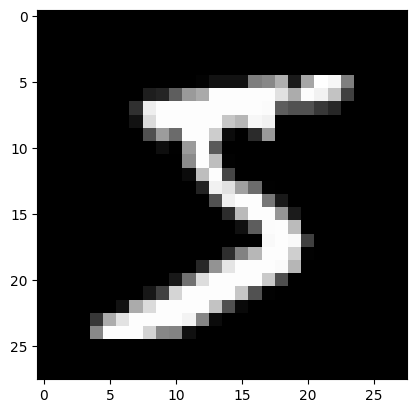

In [ ]:
from matplotlib import pyplot
import numpy as np

example_image_reshaped = example_image.reshape((28, 28))
print(f"Example image reshaped: \n{example_image_reshaped}")

pyplot.imshow(example_image_reshaped, cmap="gray")
example_label = y_train[0]
print(f"Example label: {example_label}")


Makes sense. So now our tensor is shaped (28, 28), how should we interpret this. The first dimension can be thought of as each pixels row, and the second dimension can be thought of as the column. To see how, lets artificially crop the image.

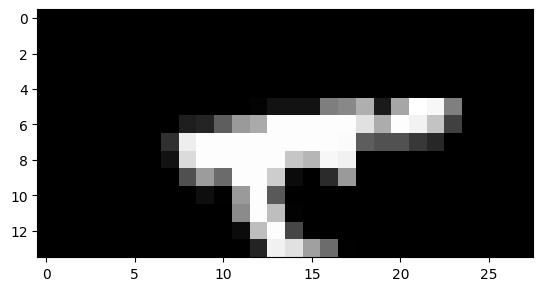

In [ ]:
cropped_along_horizontal_axis = example_image_reshaped[:len(example_image_reshaped)//2]
pyplot.imshow(cropped_along_horizontal_axis, cmap="gray")

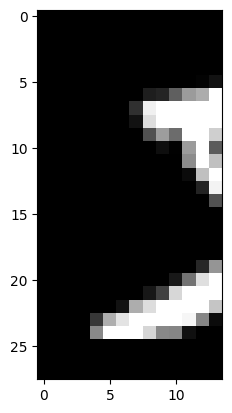

In [ ]:
cropped_along_vertical_axis = example_image_reshaped[:, :len(example_image_reshaped)//2]
pyplot.imshow(cropped_along_vertical_axis, cmap="gray")

## Part II: First Pass Convolutional Model

First we are going to step by step make a convolutional model which categorises the images.

From some online research I found a "general" setup:

> We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

That comes from [this tutorial](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/pc/exercises/image_classification_part1.ipynb?utm_source=practicum-IC&utm_campaign=colab-external&utm_medium=referral&hl=en&utm_content=imageexercise1-colab#scrollTo=5oqBkNBJmtUv). First, lets do some package imports.

In [ ]:
import torch
from torch import nn

# set random seed

torch.manual_seed(42)


### The convolution layers.

First, lets see how the convolution layers work. Lets take the reshaped example image and pass it through some example convolutional layers to inspect their behavior.

Convolutional layers expect tensors of the form $
 (C, H, W) $ where H and W are the height and width respectively in pixels of the image, and C are the channels of the image. Most images have a channel of 3, representing the exact colour in the pixel via a RGB (red-green-blue) coordinate. However, our image is grayscale, and therefore one-dimensional. Therefore, we simply need to unsqueeze the original 28x28 images to have an extra 1-dimension to the tensor to fit the input specifications.

In [ ]:
example_image_tensor = torch.tensor(example_image_reshaped, dtype=torch.float32).unsqueeze(0)

conv_layer_1_filter = nn.Conv2d(1, 1, 3) # the arguments here are (channel, num_filters, convolution_pixel_size)
output_1_filter = conv_layer_1_filter(example_image_tensor)

conv_layer_16_filter = nn.Conv2d(1, 16, 3) # the arguments here are (channel, num_filters, convolution_pixel_size)
output_16_filter = conv_layer_16_filter(example_image_tensor)

print(output_1_filter.shape)
print(output_16_filter.shape)

torch.Size([1, 26, 26])
torch.Size([16, 26, 26])


Lets just quickly see what this would look like if we did have multiple channels

In [ ]:
example_image_tensor_3_channels = example_image_tensor.repeat(3, 1, 1)

print(f"New tensor shape: {example_image_tensor_3_channels.shape}")

conv_layer_1_filter_3_channels = nn.Conv2d(3, 1, 3)

output_1_filter_3_channels = conv_layer_1_filter_3_channels(example_image_tensor_3_channels)

print(f"Output shape: {output_1_filter_3_channels.shape}")

New tensor shape: torch.Size([3, 28, 28])
Output shape: torch.Size([1, 26, 26])


Next, lets observe how max pooling works.

In [ ]:
max_pool_layer = nn.MaxPool2d(2)

output_max_pool = max_pool_layer(output_16_filter)

print(output_max_pool.shape)

torch.Size([16, 13, 13])


We've halved the height and width of the filters by taking only the most significant values for each 2x2 square in each filter. Lets take an example, max pool it, and observe.

In [ ]:
example = torch.rand(1, 26, 26)
max_pooled_example = max_pool_layer(example)
print(example[0, :2])
print(max_pooled_example[0, 0])

tensor([[0.2025, 0.0598, 0.1302, 0.1858, 0.2000, 0.3584, 0.1114, 0.8518, 0.0882,
         0.0274, 0.7951, 0.3635, 0.9981, 0.6518, 0.6825, 0.2202, 0.1669, 0.7074,
         0.5276, 0.3993, 0.4370, 0.7868, 0.8666, 0.2578, 0.5837, 0.5975],
        [0.2955, 0.7383, 0.8933, 0.8016, 0.2196, 0.2223, 0.6967, 0.6907, 0.4075,
         0.1343, 0.7347, 0.6276, 0.3260, 0.3284, 0.9082, 0.8363, 0.6409, 0.0134,
         0.5114, 0.4950, 0.8751, 0.1496, 0.5734, 0.6218, 0.0454, 0.9475]])
tensor([0.7383, 0.8933, 0.3584, 0.8518, 0.4075, 0.7951, 0.9981, 0.9082, 0.7074,
        0.5276, 0.8751, 0.8666, 0.9475])


It's a little hard to read, but you can see by taking the first two elements of the first and second row in the example, the highest of those will be represented in the max-pooled output. Lets spell it out a bit more explicitly.

In [ ]:
def explicit_max_pool(i):
  kernel = example[0][0, i:i+2].tolist() + example[0][1, i:i+2].tolist()
  print(f"The current kernel captures values: {kernel}. The max pooled value is {max(kernel)}")

explicit_max_pool(1)

The current kernel captures values: [0.05976736545562744, 0.1301988959312439, 0.7382749915122986, 0.8932694792747498]. The max pooled value is 0.8932694792747498


Now we understand these processes, lets make our network matching the specifications laid out above. Note, by the way, the flatten process simply stretches out the dimensions of the tensor into one long array, while ReLU converts all values in the tensor below 0 to 0.

In [ ]:
class ConvolutionalNetworkV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.sequence = nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64, 10)
    )

  def forward(self, x):
    return self.sequence(x)

In [ ]:
conv_net_v1 = ConvolutionalNetworkV1()
output_v1 = conv_net_v1(example_image_tensor.unsqueeze(0))
output_v1.squeeze()

tensor([ 0.1162, -0.1591,  0.0045, -0.1229,  0.0442, -0.0914, -0.0288,  0.1358,
         0.0969,  0.0387], grad_fn=<SqueezeBackward0>)

The model is outputting data in the correct format! Hooray! Lets send our model to the GPU and build a training loop.

In [ ]:
if torch.cuda.is_available():
  conv_net_v1.cuda()

In [ ]:
optim = torch.optim.Adam(conv_net_v1.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)

x_valid_tensor = torch.tensor(x_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.int64)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
valid_dataset = torch.utils.data.TensorDataset(x_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)

In [ ]:
def calculate_validation_loss_and_f1(model, valid_dataloader):
  model.eval()
  total_loss = 0
  predicted_labels = []
  true_labels = []
  for batch in valid_dataloader:
    x, y = batch
    x_reshaped = x.unsqueeze(1).reshape(-1, 1, 28, 28).to("cuda")
    y = y.to("cuda")
    output = model(x_reshaped)
    loss = loss_function(output, y)
    total_loss += loss.item()
  return total_loss / len(valid_dataloader), multiclass_f1_score(output, y, num_classes=10, average='weighted')

In [ ]:
epochs = 10
show_loss = False
train = False

if train:

  for epoch in range(epochs):
    conv_net_v1.train()
    for i, batch in enumerate(train_dataloader):
      x, y = batch
      optim.zero_grad()
      x_reshaped = x.unsqueeze(1).reshape(-1, 1, 28, 28).to("cuda")
      y = y.to("cuda")
      output = conv_net_v1(x_reshaped)
      loss = loss_function(output, y)
      loss.backward()
      optim.step()

      if show_loss and i % 100 == 0:
        print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")


    validation_loss, f1 = calculate_validation_loss_and_f1(conv_net_v1, valid_dataloader)
    print(f"Epoch: {epoch}, Validation Loss: {validation_loss}, F1: {f1}")

In [ ]:
conv_net_v1.eval().to("cpu")

ConvolutionalNetworkV1(
  (sequence): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
conv_net_v1(example_image_tensor.unsqueeze(0).reshape(-1, 1, 28, 28)).max(1).indices

tensor([7])

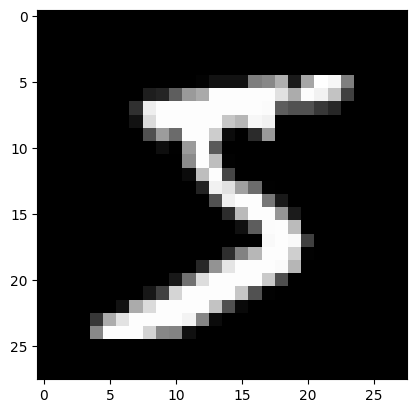

In [ ]:
pyplot.imshow(example_image_reshaped, cmap="gray")

It worked! Lets try another.

In [ ]:
example_2 = x_train[1]
example_2_reshaped = example_2.reshape((28, 28))
example_2_tensor = torch.tensor(example_2_reshaped, dtype=torch.float32).unsqueeze(0)

conv_net_v1(example_2_tensor.unsqueeze(0).reshape(-1, 1, 28, 28)).max(1).indices

tensor([0])

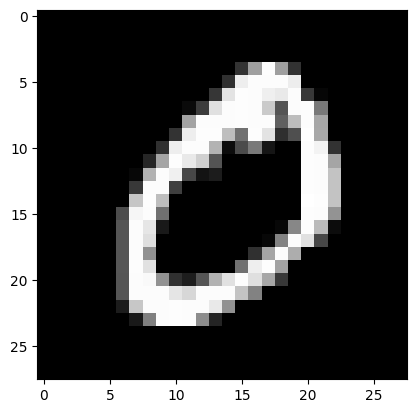

In [ ]:
pyplot.imshow(example_2_reshaped, cmap="gray")

Another success! Time to move on.

## Part III: Developing a GAN

Generative Adversarial Networks are composed of a generator network and a discriminator network. Discriminator networks have the responsibility of determining true examples of a category from false examples of a category. We already have a discriminator whose current responsibility is classifying the images into each digit.

The generator is a model which takes in random noise and generates an output which should look like the training images, at least enough to fool the discriminator. For our purposes, lets just make this a standard feedforward neural network.

First, lets modify our convolutional network to make it into a discriminator which classifies inputs images as 1 (an image from the training set) or 0 (an image created by the generator).

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.sequence = nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64, 1) # THIS IS THE ONLY CHANGED LINE FROM BEFORE
    )

  def forward(self, x):
    return self.sequence(x)

discriminator = Discriminator()
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=0.001)

Now let's create the generator.

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.sequence = nn.Sequential(
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.sequence(x)

generator = Generator()
generator_optim = torch.optim.Adam(generator.parameters(), lr=0.001)

We also need to be able to create our datasets. Lets make some functions to do this.

In [ ]:
def create_true_image_dataloader(device):
  true_images = torch.tensor(x_train, dtype=torch.float32).to(device)
  dataset = torch.utils.data.TensorDataset(true_images)
  return torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Now we can create our annotated dataset, we need a loss function to train the discriminator. This can just be BCE loss.

In [ ]:
loss_function = nn.BCEWithLogitsLoss()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

generated_image_vectors = []

def train_epoch(epoch, discriminator, generator, discriminator_optim, generator_optim, generator_config):
  dataloader = create_true_image_dataloader(device)
  discriminator.train().to(device)
  generator.train().to(device)

  epoch_d_loss = 0
  epoch_g_loss = 0

  for batch in tqdm.tqdm(dataloader):
    # train discriminator

    batch_true_images = batch[0].reshape(-1, 1, 28, 28)

    discriminator_optim.zero_grad()
    output = discriminator(batch_true_images)
    t_loss = loss_function(output.squeeze(), torch.ones(batch_true_images.shape[0], dtype=torch.float32, device=device))

    noise = torch.randn(batch_true_images.shape[0], 100, device=device)
    if generator_config == "conv":
      noise = noise.reshape(-1, 100, 1, 1)
    generated_images = generator(noise).reshape(-1, 1, 28, 28)
    output = discriminator(generated_images)
    f_loss = loss_function(output.squeeze(), torch.zeros(batch_true_images.shape[0], dtype=torch.float32, device=device))

    loss = t_loss + f_loss

    loss.backward()
    discriminator_optim.step()

    epoch_d_loss += loss.item()

    # train generator

    generator_optim.zero_grad()

    noise = torch.randn(batch_true_images.shape[0]*2, 100, device=device)
    if generator_config == "conv":
      noise = noise.reshape(-1, 100, 1, 1)
    generated_images = generator(noise).reshape(-1, 1, 28, 28)
    output = discriminator(generated_images)
    loss = loss_function(output.squeeze(), torch.ones(batch_true_images.shape[0]*2, dtype=torch.float32, device=device))

    loss.backward()
    generator_optim.step()

    epoch_g_loss += loss.item()

  noise = torch.randn(1, 100, device=device) if generator_config == "linear" else torch.randn(1, 100, 1, 1, device=device)
  with torch.no_grad():
    generated_image = generated_image_vectors.append(generator(noise).reshape(28, 28).cpu().numpy())

  print(f"Epoch {epoch} discriminator loss: {epoch_d_loss / len(dataloader)}")
  print(f"Epoch {epoch} generator loss: {epoch_g_loss / len(dataloader)}")

In [ ]:
# for epoch in range(10):
#   train_epoch(
#       epoch,
#       generator_config="linear",
#       generator=generator,
#       generator_optim=generator_optim,
#       discriminator=discriminator,
#       discriminator_optim=discriminator_optim
#       )

100%|██████████| 313/313 [00:02<00:00, 106.19it/s]


Epoch 0 discriminator loss: 0.24760236821402185
Epoch 0 generator loss: 3.327409160594209


100%|██████████| 313/313 [00:02<00:00, 130.37it/s]


Epoch 1 discriminator loss: 0.1028066608339203
Epoch 1 generator loss: 4.2310678025784965


100%|██████████| 313/313 [00:02<00:00, 137.69it/s]


Epoch 2 discriminator loss: 0.0949803687440166
Epoch 2 generator loss: 5.093316715746261


100%|██████████| 313/313 [00:02<00:00, 134.77it/s]


Epoch 3 discriminator loss: 0.14817938830751104
Epoch 3 generator loss: 4.220927638367723


100%|██████████| 313/313 [00:02<00:00, 138.12it/s]


Epoch 4 discriminator loss: 0.22695956829364022
Epoch 4 generator loss: 4.097252654572264


100%|██████████| 313/313 [00:02<00:00, 108.54it/s]


Epoch 5 discriminator loss: 0.057025621654822854
Epoch 5 generator loss: 4.929547384524117


100%|██████████| 313/313 [00:02<00:00, 135.63it/s]


Epoch 6 discriminator loss: 0.008535527269736814
Epoch 6 generator loss: 5.967687871890327


100%|██████████| 313/313 [00:02<00:00, 135.02it/s]


Epoch 7 discriminator loss: 0.006281980402741065
Epoch 7 generator loss: 6.64454282815464


100%|██████████| 313/313 [00:02<00:00, 134.86it/s]


Epoch 8 discriminator loss: 0.0023400333374797738
Epoch 8 generator loss: 8.168969430100804


100%|██████████| 313/313 [00:02<00:00, 132.04it/s]

Epoch 9 discriminator loss: 0.0009132110731014272
Epoch 9 generator loss: 8.995951283854037


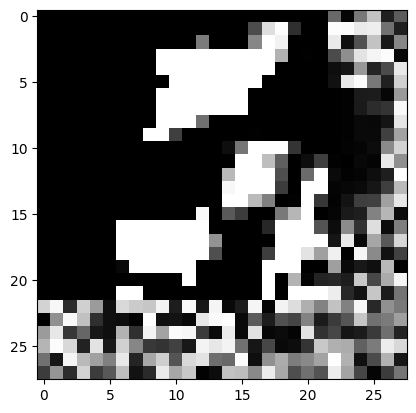

In [ ]:
pyplot.imshow(generated_image_vectors[5], cmap="gray")

Our model is learning! The issue, however, is that our generator sucks. Lets make a new one, following the inverse of our discriminator network. This follows a [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on GANs released on PyTorch's website

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 50, 4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            nn.ReLU(True),
            nn.ConvTranspose2d(50, 25, 3, stride=2, padding=1),
            nn.BatchNorm2d(25),
            nn.ReLU(True),
            nn.ConvTranspose2d(25, 10, 4, stride=2, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
            nn.ConvTranspose2d(10, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

generator = Generator()
generator_optim = torch.optim.Adam(generator.parameters(), lr=0.01)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, stride=1, padding=0),  # Output: (batch, 256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # Output: (batch, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # Output: (batch, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),     # Output: (batch, 1, 32, 32)
            nn.Conv2d(1, 1, kernel_size=5),   # Output: (batch, 1, 28, 28)
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


    def forward(self, input):
        return self.main(input)


In [ ]:
# generator = Generator()
# generator_optim = torch.optim.Adam(generator.parameters(), lr=0.001)
# discriminator = Discriminator()
# discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# for epoch in rxange(10):
#   train_epoch(
#       epoch,
#       generator_config="conv",
#       generator=generator,
#       generator_optim=generator_optim,
#       discriminator=discriminator,
#       discriminator_optim=discriminator_optim
#       )

100%|██████████| 782/782 [00:12<00:00, 62.77it/s]


Epoch 0 discriminator loss: 0.5761917787163383
Epoch 0 generator loss: 2.4004365456531116


100%|██████████| 782/782 [00:12<00:00, 63.12it/s]


Epoch 1 discriminator loss: 0.22228397473530925
Epoch 1 generator loss: 3.7944013714180578


100%|██████████| 782/782 [00:12<00:00, 62.81it/s]


Epoch 2 discriminator loss: 0.08788844587696988
Epoch 2 generator loss: 5.184756619241232


100%|██████████| 782/782 [00:12<00:00, 62.63it/s]


Epoch 3 discriminator loss: 0.11592029213093702
Epoch 3 generator loss: 5.250686692459809


100%|██████████| 782/782 [00:12<00:00, 62.38it/s]


Epoch 4 discriminator loss: 0.11455937770917021
Epoch 4 generator loss: 5.376738389129834


100%|██████████| 782/782 [00:12<00:00, 61.87it/s]


Epoch 5 discriminator loss: 0.06450210884689828
Epoch 5 generator loss: 6.102612827744935


100%|██████████| 782/782 [00:12<00:00, 61.72it/s]


Epoch 6 discriminator loss: 0.0475751004625003
Epoch 6 generator loss: 6.628421924303255


100%|██████████| 782/782 [00:12<00:00, 61.67it/s]


Epoch 7 discriminator loss: 0.03438266346489234
Epoch 7 generator loss: 7.053982540164762


100%|██████████| 782/782 [00:12<00:00, 61.28it/s]


Epoch 8 discriminator loss: 0.045600379240000585
Epoch 8 generator loss: 7.180107214109367


100%|██████████| 782/782 [00:12<00:00, 61.11it/s]

Epoch 9 discriminator loss: 0.019815483160079014
Epoch 9 generator loss: 7.711909533766529


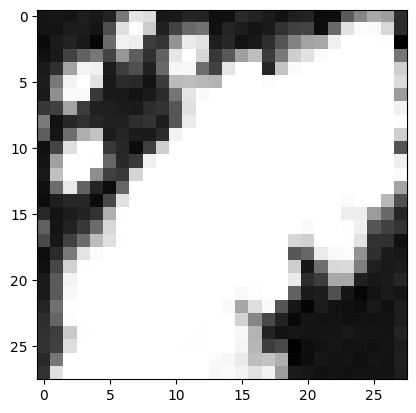

In [ ]:
pyplot.imshow(generated_image_vectors[4], cmap="gray")

It is still pretty meh, to be honest.

In [ ]:


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, stride=1, padding=0),  # Output: (batch, 256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # Output: (batch, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # Output: (batch, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),

            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),     # Output: (batch, 1, 32, 32)
            nn.Conv2d(1, 1, kernel_size=5),   # Output: (batch, 1, 28, 28)
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


    def forward(self, input):
        return self.main(input)


In [ ]:
# generator = Generator()
# generator_optim = torch.optim.AdamW(generator.parameters(), lr=0.001)
# discriminator = Discriminator()
# discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=0.001)
# generated_image_vectors = []

# for epoch in range(10):
#   train_epoch(
#       epoch,
#       generator_config="conv",
#       generator=generator,
#       generator_optim=generator_optim,
#       discriminator=discriminator,
#       discriminator_optim=discriminator_optim
#       )

100%|██████████| 782/782 [00:12<00:00, 60.30it/s]


Epoch 0 discriminator loss: 0.48583006164263887
Epoch 0 generator loss: 2.6255190828838924


100%|██████████| 782/782 [00:13<00:00, 60.08it/s]


Epoch 1 discriminator loss: 0.29383651701176106
Epoch 1 generator loss: 3.684073255571258


100%|██████████| 782/782 [00:12<00:00, 60.30it/s]


Epoch 2 discriminator loss: 0.19781360600847522
Epoch 2 generator loss: 4.722648992410401


100%|██████████| 782/782 [00:12<00:00, 60.97it/s]


Epoch 3 discriminator loss: 0.12190783031880581
Epoch 3 generator loss: 5.332124059462486


100%|██████████| 782/782 [00:12<00:00, 60.91it/s]


Epoch 4 discriminator loss: 0.10946333868325564
Epoch 4 generator loss: 6.854091748404686


100%|██████████| 782/782 [00:12<00:00, 60.89it/s]


Epoch 5 discriminator loss: 0.09343760854357977
Epoch 5 generator loss: 6.722528471361341


100%|██████████| 782/782 [00:12<00:00, 60.86it/s]


Epoch 6 discriminator loss: 0.09361723912882057
Epoch 6 generator loss: 6.596367855739715


100%|██████████| 782/782 [00:12<00:00, 60.77it/s]


Epoch 7 discriminator loss: 0.08250338326845563
Epoch 7 generator loss: 7.560284306859726


100%|██████████| 782/782 [00:12<00:00, 60.76it/s]


Epoch 8 discriminator loss: 0.08038965764766745
Epoch 8 generator loss: 7.8199690121518985


100%|██████████| 782/782 [00:12<00:00, 60.92it/s]

Epoch 9 discriminator loss: 0.07779099687689703
Epoch 9 generator loss: 7.9474693718163865


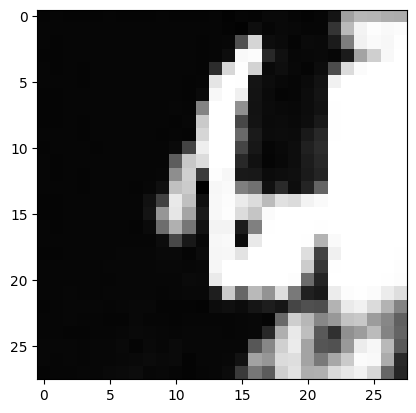

In [ ]:
pyplot.imshow(generated_image_vectors[1], cmap="gray")